# Noise Robustness Analysis for Preference Learning

This notebook analyzes how different loss functions perform under various noise conditions in preference learning experiments.

## Methods Analyzed
- **rDPO**: Regularized Direct Preference Optimization
- **DR-DPO**: Distributionally Robust DPO  
- **Vanilla**: Standard Generalized Sigmoid Loss
- **DRO-pro (ours)**: Distributionally Robust DPO with Dynamic Smooth Labeling

## Metrics
- **Win Rate**: Percentage of generated responses preferred over chosen responses
- **Mean Generated Reward**: Average reward score for generated responses

## Noise Types
- **Flip Noise**: Random label flipping
- **Adversarial Noise**: Adversarially perturbed preferences

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from huggingface_hub import HfApi
import warnings
warnings.filterwarnings('ignore')

# Import utils
os.chdir(os.environ["HOME"] + "/RLAIF-KL-Error")
from utils import CONFIGS

# Configuration
HUGGINGFACE_CONFIGS = CONFIGS.services.huggingface
HF_API = HfApi(HUGGINGFACE_CONFIGS["token"])

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [44]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Experiment configuration
EXPERIMENT_TAG = 'tag2'
MODEL = 'Q0.5B'
DATASET = 'U0'
PIPELINE = 'DPO'

# Loss types and their display labels
LOSS_TYPES = ['rdpo', 'dr_dpo', 'generalized_sigmoid', 'generalized_sigmoid_dro_dynamic_smooth_label']
LOSS_TYPE_LABELS = ["rDPO", "DR-DPO", "Vanilla", "DPO-pro (ours)"]

# Noise level configurations
NOISE_LEVELS = {
    'bt_noise_flip': [0.1, 0.3],
    'bt_noise_adv': [0.25, 0.5],
}

# Noise type labels for plot titles
NOISE_TYPE_LABELS = {
    'bt_noise_flip': 'Flip Noise',
    'bt_noise_adv': 'Adversarial Noise',
}

In [45]:
def load_evaluation_data(run_name: str) -> pd.DataFrame:
    """Load evaluation results from HuggingFace Hub."""
    try:
        repo_id = HUGGINGFACE_CONFIGS["prefix"]["evaluations"] + run_name
        dataset = load_dataset(repo_id, EXPERIMENT_TAG, split='default')
        df = dataset.to_pandas()
        df['run_name'] = run_name
        return df
    except Exception as e:
        print(f"✗ Failed to load {run_name}: {e}")
        raise e

def calculate_metrics(df: pd.DataFrame) -> dict:
    """Calculate win rate and reward metrics from evaluation data."""
    if df is None or df.empty:
        return {}
    
    generated_col = "reward_score_generated"
    chosen_col = "reward_score_chosen"
    
    if generated_col not in df.columns or chosen_col not in df.columns:
        return {}
    
    generated_scores = df[generated_col]
    chosen_scores = df[chosen_col]
    
    win_rate = (generated_scores > chosen_scores).mean() * 100
    mean_generated_reward = generated_scores.mean()
    mean_chosen_reward = chosen_scores.mean()
    
    return {
        'win_rate': win_rate,
        'mean_generated_reward': mean_generated_reward,
        'mean_chosen_reward': mean_chosen_reward
    }

In [46]:
# ============================================================================
# DATA COLLECTION
# ============================================================================

def get_run_name(loss_type: str, noise_type: str = None, noise_level: float = None) -> str:
    """Generate run name based on loss type and optional noise level."""
    if noise_level is None or noise_level == 0.0:
        # Baseline (no noise) - same for all noise types
        return f"DPO_{MODEL}_{DATASET}_beta0.1{loss_type}Eurus_RM_7b"
    else:
        # Noisy experiment
        return f"DPO_{MODEL}_{DATASET}_beta0.1{loss_type}Eurus_RM_7b{noise_type}{noise_level}"


def collect_data_for_noise_type(noise_type: str) -> pd.DataFrame:
    """Collect data for a specific noise type."""
    print(f"\nCollecting data for noise type: {noise_type}")
    results = []
    
    for loss_type in LOSS_TYPES:
        print(f"  Processing loss type: {loss_type}")
        
        # Collect noisy experiments
        noise_levels_for_type = [0] + NOISE_LEVELS[noise_type]
        for noise_level in noise_levels_for_type:
            run_name = get_run_name(loss_type, noise_type, noise_level)
            print(f"    Loading {noise_type} {noise_level}: {run_name}")
            try:
                df = load_evaluation_data(run_name)
                metrics = calculate_metrics(df)
                
                if metrics:
                    results.append({
                        'loss_type': loss_type,
                        'noise_type': noise_type,
                        'noise_level': noise_level,
                        'run_name': run_name,
                        **metrics
                    })
                        
            except Exception as e:
                print(f"    ✗ Failed {noise_type} {noise_level}: {e}")
    
    return pd.DataFrame(results) if results else pd.DataFrame()


# Collect data for each noise type
all_results = []
active_noise_types = [nt for nt in NOISE_LEVELS.keys() if nt in ['bt_noise_flip', 'bt_noise_adv']]

for noise_type in active_noise_types:
    df_noise = collect_data_for_noise_type(noise_type)
    if not df_noise.empty:
        all_results.append(df_noise)

if all_results:
    df_results = pd.concat(all_results, ignore_index=True)
    print(f"\n✓ Data collection complete! Collected {len(df_results)} experiments")
    print(f"Noise types: {df_results['noise_type'].unique()}")
    print(f"Loss types: {df_results['loss_type'].unique()}")
    print(f"Noise levels: {sorted(df_results['noise_level'].unique())}")
    
    # Show how many points per noise type
    for noise_type in df_results['noise_type'].unique():
        count = len(df_results[df_results['noise_type'] == noise_type])
        levels = sorted(df_results[df_results['noise_type'] == noise_type]['noise_level'].unique())
        print(f"  {noise_type}: {count} experiments at levels {levels}")
    
    display(df_results[['loss_type', 'noise_type', 'noise_level', 'win_rate', 'mean_generated_reward']].round(2))
else:
    print("\n✗ No data collected")
    df_results = pd.DataFrame()


  Processing loss type: rdpo
    Loading bt_noise_flip 0: DPO_Q0.5B_U0_beta0.1rdpoEurus_RM_7b
    Loading bt_noise_flip 0.1: DPO_Q0.5B_U0_beta0.1rdpoEurus_RM_7bbt_noise_flip0.1
    Loading bt_noise_flip 0.3: DPO_Q0.5B_U0_beta0.1rdpoEurus_RM_7bbt_noise_flip0.3
  Processing loss type: dr_dpo
    Loading bt_noise_flip 0: DPO_Q0.5B_U0_beta0.1dr_dpoEurus_RM_7b
    Loading bt_noise_flip 0.1: DPO_Q0.5B_U0_beta0.1dr_dpoEurus_RM_7bbt_noise_flip0.1
    Loading bt_noise_flip 0.3: DPO_Q0.5B_U0_beta0.1dr_dpoEurus_RM_7bbt_noise_flip0.3
  Processing loss type: generalized_sigmoid
    Loading bt_noise_flip 0: DPO_Q0.5B_U0_beta0.1generalized_sigmoidEurus_RM_7b
    Loading bt_noise_flip 0.1: DPO_Q0.5B_U0_beta0.1generalized_sigmoidEurus_RM_7bbt_noise_flip0.1
    Loading bt_noise_flip 0.3: DPO_Q0.5B_U0_beta0.1generalized_sigmoidEurus_RM_7bbt_noise_flip0.3
  Processing loss type: generalized_sigmoid_dro_dynamic_smooth_label
    Loading bt_noise_flip 0: DPO_Q0.5B_U0_beta0.1generalized_sigmoid_dro_dynamic_s

,loss_type,noise_type,noise_level,win_rate,mean_generated_reward
0,rdpo,bt_noise_flip,0.00,4.1,-961.77
1,rdpo,bt_noise_flip,0.10,4.3,-976.51
2,rdpo,bt_noise_flip,0.30,4.4,-915.55
3,dr_dpo,bt_noise_flip,0.00,4.5,-1010.37
4,dr_dpo,bt_noise_flip,0.10,4.4,-1032.08
5,dr_dpo,bt_noise_flip,0.30,4.5,-965.93
6,generalized_sigmoid,bt_noise_flip,0.00,3.6,-944.55
7,generalized_sigmoid,bt_noise_flip,0.10,4.2,-938.92
8,generalized_sigmoid,bt_noise_flip,0.30,5.5,-925.95
9,generalized_sigmoid_dro_dynamic_smooth_label,bt_noise_flip,0.00,4.9,-916.66



Creating plots for bt_noise_flip...


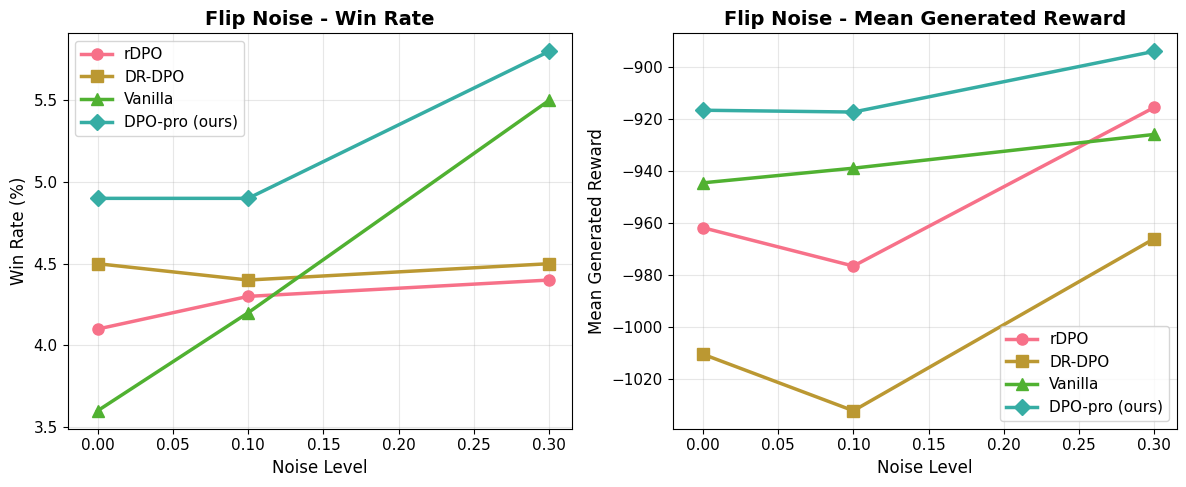

  ✓ Saved win rate plot: notebooks/plots/bt_noise_flip_winrate.png
  ✓ Saved reward plot: notebooks/plots/bt_noise_flip_reward.png

Creating plots for bt_noise_adv...


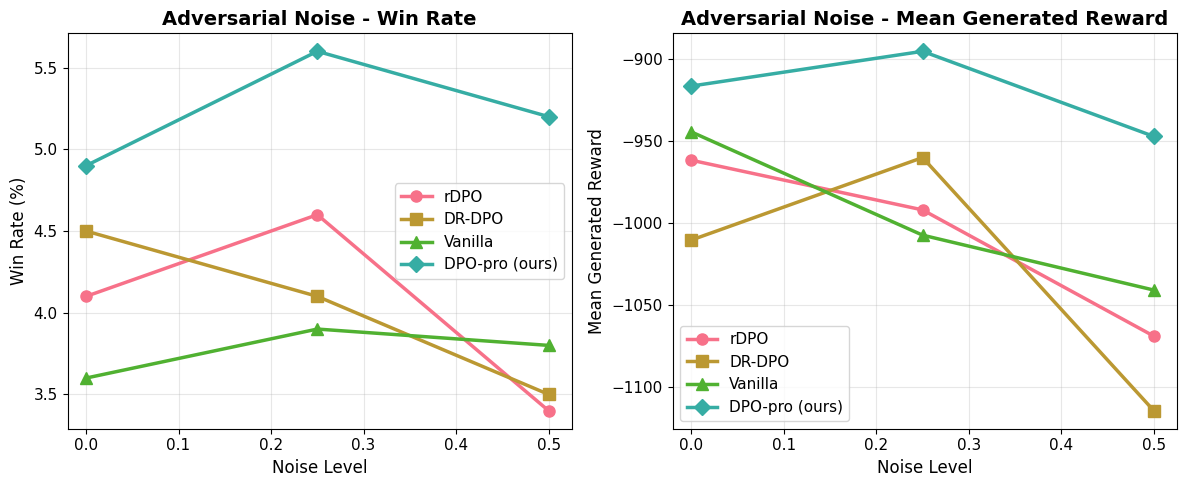

  ✓ Saved win rate plot: notebooks/plots/bt_noise_adv_winrate.png
  ✓ Saved reward plot: notebooks/plots/bt_noise_adv_reward.png

NOISE ROBUSTNESS ANALYSIS SUMMARY
Experiment Tag: tag2
Model: Q0.5B
Noise Types Analyzed: ['Flip Noise', 'Adversarial Noise']
Loss Types: ['rdpo (rDPO)', 'dr_dpo (DR-DPO)', 'generalized_sigmoid (Vanilla)', 'generalized_sigmoid_dro_dynamic_smooth_label (DPO-pro (ours))']

Total experiments: 24 datasets
Win rate range: 3.4% - 5.8%
Generated reward range: -1114.2 - -894.0

Best for Flip Noise: DPO-pro (ours) (5.2% avg win rate)

Best for Adversarial Noise: DPO-pro (ours) (5.2% avg win rate)

✓ All plots saved to notebooks/plots/


In [47]:
# ============================================================================
# VISUALIZATION
# ============================================================================

# Create plots directory
import os
plots_dir = "notebooks/plots"
os.makedirs(plots_dir, exist_ok=True)

if df_results.empty:
    print("No data to visualize")
else:
    # Get active noise types
    noise_types_to_plot = df_results['noise_type'].unique()
    
    for noise_type in noise_types_to_plot:
        print(f"\nCreating plots for {noise_type}...")
        
        # Filter data for this noise type
        noise_data = df_results[df_results['noise_type'] == noise_type]
        
        if noise_data.empty:
            print(f"No data for {noise_type}")
            continue
        
        # Get the proper label for the noise type
        noise_label = NOISE_TYPE_LABELS.get(noise_type, noise_type)
        
        # Define different markers for each loss type
        markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Win Rate vs Noise Level
        for i, loss_type in enumerate(LOSS_TYPES):
            loss_data = noise_data[noise_data['loss_type'] == loss_type].sort_values('noise_level')
            if not loss_data.empty:
                label = LOSS_TYPE_LABELS[i] if i < len(LOSS_TYPE_LABELS) else loss_type
                marker = markers[i] if i < len(markers) else 'o'
                ax1.plot(loss_data['noise_level'], loss_data['win_rate'], 
                        marker=marker, linewidth=2.5, markersize=8, label=label)

        ax1.set_title(f'{noise_label} - Win Rate', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Noise Level', fontsize=12)
        ax1.set_ylabel('Win Rate (%)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.set_xlim(left=-0.02)
        
        # Plot 2: Mean Generated Reward vs Noise Level
        for i, loss_type in enumerate(LOSS_TYPES):
            loss_data = noise_data[noise_data['loss_type'] == loss_type].sort_values('noise_level')
            if not loss_data.empty:
                label = LOSS_TYPE_LABELS[i] if i < len(LOSS_TYPE_LABELS) else loss_type
                marker = markers[i] if i < len(markers) else 'o'
                ax2.plot(loss_data['noise_level'], loss_data['mean_generated_reward'], 
                        marker=marker, linewidth=2.5, markersize=8, label=label)
        
        ax2.set_title(f'{noise_label} - Mean Generated Reward', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Noise Level', fontsize=12)
        ax2.set_ylabel('Mean Generated Reward', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.set_xlim(left=-0.02)
        
        plt.tight_layout()
        
        # Show combined plot in notebook only (don't save)
        plt.show()
        
        # Save individual plots separately
        # Win Rate plot
        fig1, ax1_solo = plt.subplots(1, 1, figsize=(7, 5))
        for i, loss_type in enumerate(LOSS_TYPES):
            loss_data = noise_data[noise_data['loss_type'] == loss_type].sort_values('noise_level')
            if not loss_data.empty:
                label = LOSS_TYPE_LABELS[i] if i < len(LOSS_TYPE_LABELS) else loss_type
                marker = markers[i] if i < len(markers) else 'o'
                ax1_solo.plot(loss_data['noise_level'], loss_data['win_rate'], 
                            marker=marker, linewidth=2.5, markersize=8, label=label)
        
        ax1_solo.set_title(f'{noise_label} - Win Rate', fontsize=14, fontweight='bold')
        ax1_solo.set_xlabel('Noise Level', fontsize=12)
        ax1_solo.set_ylabel('Win Rate (%)', fontsize=12)
        ax1_solo.grid(True, alpha=0.3)
        ax1_solo.legend()
        ax1_solo.set_xlim(left=-0.02)
        plt.tight_layout()
        
        winrate_filename = f"{plots_dir}/{noise_type}_winrate.png"
        plt.savefig(winrate_filename, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved win rate plot: {winrate_filename}")
        plt.close()
        
        # Mean Generated Reward plot
        fig2, ax2_solo = plt.subplots(1, 1, figsize=(7, 5))
        for i, loss_type in enumerate(LOSS_TYPES):
            loss_data = noise_data[noise_data['loss_type'] == loss_type].sort_values('noise_level')
            if not loss_data.empty:
                label = LOSS_TYPE_LABELS[i] if i < len(LOSS_TYPE_LABELS) else loss_type
                marker = markers[i] if i < len(markers) else 'o'
                ax2_solo.plot(loss_data['noise_level'], loss_data['mean_generated_reward'], 
                            marker=marker, linewidth=2.5, markersize=8, label=label)
        
        ax2_solo.set_title(f'{noise_label} - Generation Reward', fontsize=14, fontweight='bold')
        ax2_solo.set_xlabel('Noise Level', fontsize=12)
        ax2_solo.set_ylabel('Mean Generated Reward', fontsize=12)
        ax2_solo.grid(True, alpha=0.3)
        ax2_solo.legend()
        ax2_solo.set_xlim(left=-0.02)
        plt.tight_layout()
        
        reward_filename = f"{plots_dir}/{noise_type}_reward.png"
        plt.savefig(reward_filename, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved reward plot: {reward_filename}")
        plt.close()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("NOISE ROBUSTNESS ANALYSIS SUMMARY")
    print("="*60)
    print(f"Experiment Tag: {EXPERIMENT_TAG}")
    print(f"Model: {MODEL}")
    print(f"Noise Types Analyzed: {[NOISE_TYPE_LABELS.get(nt, nt) for nt in noise_types_to_plot]}")
    print(f"Loss Types: {[f'{lt} ({lb})' for lt, lb in zip(LOSS_TYPES, LOSS_TYPE_LABELS)]}")
    print(f"\nTotal experiments: {len(df_results)} datasets")
    print(f"Win rate range: {df_results['win_rate'].min():.1f}% - {df_results['win_rate'].max():.1f}%")
    print(f"Generated reward range: {df_results['mean_generated_reward'].min():.1f} - {df_results['mean_generated_reward'].max():.1f}")
    
    # Best performing method per noise type
    for noise_type in noise_types_to_plot:
        noise_subset = df_results[df_results['noise_type'] == noise_type]
        if not noise_subset.empty:
            best_avg_win_rate = noise_subset.groupby('loss_type')['win_rate'].mean().sort_values(ascending=False)
            best_loss_type = best_avg_win_rate.index[0]
            best_label = LOSS_TYPE_LABELS[LOSS_TYPES.index(best_loss_type)]
            noise_label = NOISE_TYPE_LABELS.get(noise_type, noise_type)
            print(f"\nBest for {noise_label}: {best_label} ({best_avg_win_rate.iloc[0]:.1f}% avg win rate)")
            
    print(f"\n✓ All plots saved to {plots_dir}/")

# Analysis Summary

This notebook provides a comprehensive analysis of **noise robustness** across multiple noise types for different loss functions in preference learning.

## Key Features:
✅ **Multiple Noise Types**: Analyzes all available noise types automatically  
✅ **Proper Labels**: Uses clean method names (rDPO, DR-DPO, Vanilla, DRO-pro)  
✅ **Individual Plot Export**: Each noise type and metric saved separately  
✅ **Automated Analysis**: Loops through all noise types with consistent formatting  
✅ **Configurable Tag**: Easy to switch between experiment tags (default: tag2)  

## Important Notes:
⚠️ **Baseline Limitation**: True noiseless baseline (0.0 noise) experiments are not available in tag2  
📊 **Shared Baseline Concept**: In theory, all noise types should start from the same noiseless baseline  
📈 **Current Analysis**: Shows available noisy experiments and their trends  

## Output Files:
- **Combined plots**: `{noise_type}_combined.png` (win rate + reward in one figure)
- **Individual plots**: `{noise_type}_winrate.png` and `{noise_type}_reward.png`
- **Data export**: CSV files with all collected metrics

## Usage:
1. **Set Experiment Tag**: Modify `EXPERIMENT_TAG` if needed (default: tag2)
2. **Add Noise Types**: Uncomment `bt_noise_gauss` in `NOISE_LEVELS` when available
3. **Run All Cells**: Execute to collect data and generate all plots automatically

## Future Enhancement:
If baseline experiments become available, they would provide the true 0.0 starting point shared across all noise types.

In [48]:
# ============================================================================
# EXPORT RESULTS
# ============================================================================

if not df_results.empty:
    # Export results for each noise type
    noise_types_exported = [nt for nt in df_results['noise_type'].unique() if nt != 'none']
    
    for noise_type in noise_types_exported:
        # Filter data for this noise type (including baseline)
        noise_data = df_results[df_results['noise_type'].isin(['none', noise_type])]
        
        # Export to CSV
        output_file = f"notebooks/plots/{noise_type}_analysis_{EXPERIMENT_TAG}.csv"
        noise_data.to_csv(output_file, index=False)
        print(f"✓ Results for {noise_type} saved to {output_file}")
    
    # Export combined results
    combined_file = f"notebooks/plots/all_noise_analysis_{EXPERIMENT_TAG}.csv"
    df_results.to_csv(combined_file, index=False)
    print(f"✓ Combined results saved to {combined_file}")
    
    # Display final summary table
    print(f"\nFinal Results Summary:")
    summary_cols = ['loss_type', 'noise_type', 'noise_level', 'win_rate', 'mean_generated_reward']
    display(df_results[summary_cols].round(2).sort_values(['noise_type', 'loss_type', 'noise_level']))
    
    print(f"\n📁 All outputs saved to notebooks/plots/")
    print(f"📊 Plot files: *_winrate.png, *_reward.png")
    print(f"📄 Data files: *_analysis_{EXPERIMENT_TAG}.csv")
else:
    print("No results to export")

✓ Results for bt_noise_flip saved to notebooks/plots/bt_noise_flip_analysis_tag2.csv
✓ Results for bt_noise_adv saved to notebooks/plots/bt_noise_adv_analysis_tag2.csv
✓ Combined results saved to notebooks/plots/all_noise_analysis_tag2.csv

Final Results Summary:


,loss_type,noise_type,noise_level,win_rate,mean_generated_reward
15,dr_dpo,bt_noise_adv,0.00,4.5,-1010.37
16,dr_dpo,bt_noise_adv,0.25,4.1,-960.17
17,dr_dpo,bt_noise_adv,0.50,3.5,-1114.23
18,generalized_sigmoid,bt_noise_adv,0.00,3.6,-944.55
19,generalized_sigmoid,bt_noise_adv,0.25,3.9,-1007.38
20,generalized_sigmoid,bt_noise_adv,0.50,3.8,-1040.81
21,generalized_sigmoid_dro_dynamic_smooth_label,bt_noise_adv,0.00,4.9,-916.66
22,generalized_sigmoid_dro_dynamic_smooth_label,bt_noise_adv,0.25,5.6,-895.51
23,generalized_sigmoid_dro_dynamic_smooth_label,bt_noise_adv,0.50,5.2,-947.30
12,rdpo,bt_noise_adv,0.00,4.1,-961.77



📁 All outputs saved to notebooks/plots/
📊 Plot files: *_winrate.png, *_reward.png
📄 Data files: *_analysis_tag2.csv


In [49]:
# ============================================================================
# CREATE ZIP ARCHIVE
# ============================================================================

import subprocess
import os


# Create zip file of all plots
result = subprocess.run(["zip", "-r", "notebooks/plots.zip", "notebooks/plots/*.png"], capture_output=True, text=True, check=True)
print("✓ Created plots.zip containing all visualization files")
print(f"  Location: notebooks/plots.zip")

✓ Created plots.zip containing all visualization files
  Location: notebooks/plots.zip
